

Important: in kernel-only competitions we can't use internet connections. So I use pretrained models from here: https://www.kaggle.com/bminixhofer/pytorch-pretrained-image-models

In [1]:
#!pip install "../input/pretrained-models/pretrained-models/pretrained-models.pytorch-master"

In [2]:
import sys
package_path = "../input/efficientnet-pytorch/efficientnet-pytorch/EfficientNet-PyTorch-master"
sys.path.append(package_path)

In [3]:
# libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time 
import tqdm
from PIL import Image
train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
import copy
import cv2
import albumentations
from albumentations import torch as AT
import random


#import pretrainedmodels
from efficientnet_pytorch import EfficientNet

## Data overview

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [5]:
seed_everything(1234)

In [6]:
train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
sample_submission = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

old_train = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels_cropped.csv')




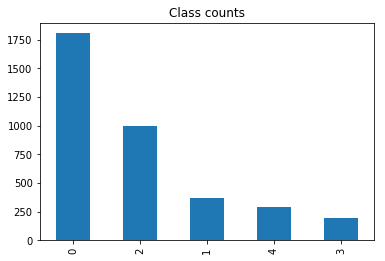

In [7]:
train['diagnosis'].value_counts().plot(kind='bar');
plt.title('Class counts');

We have a slight disbalance in data.

Personally I see little differences between images

## Data preparation

In [8]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
def prepare_labels(y):
    # From here: https://www.kaggle.com/pestipeti/keras-cnn-starter
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    y = onehot_encoded
    return y, label_encoder

In [9]:
y, le = prepare_labels(train['diagnosis'])

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [10]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def preprocess_image(image_path, desired_size=224):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image_from_gray(img)
    img = cv2.resize(img, (desired_size,desired_size))
    img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), desired_size/30) ,-4 ,128)
    
    return img

def preprocess_image_old(image_path, desired_size=224):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image_from_gray(img)
    img = cv2.resize(img, (desired_size,desired_size))
    img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), desired_size/40) ,-4 ,128)
    
    return img

In [11]:
class GlassDataset(Dataset):
    def __init__(self, df, datatype='train', transform = transforms.Compose([transforms.CenterCrop(32),transforms.ToTensor()]), y = None):
        self.df = df
        self.datatype = datatype
        if self.datatype == 'train':
            self.image_files_list = [f'../input/aptos2019-blindness-detection/{self.datatype}_images/{i}.png' for i in df['id_code'].values]
            #self.image_files_list = [i for i in df['id_code'].values]
            self.labels = y
        else:
            self.image_files_list = [f'../input/aptos2019-blindness-detection/{self.datatype}_images/{i}.png' for i in df['id_code'].values]
            self.labels = np.zeros((df.shape[0], 5))
        self.transform = transform

    def __len__(self):
        return len(self.image_files_list)

    def __getitem__(self, idx):
        img_name = self.image_files_list[idx]
        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = crop_image_from_gray(img)
        image = self.transform(image=img)
        image = image['image']

        img_name_short = self.image_files_list[idx].split('.')[0]

        label = self.labels[idx]
        if self.datatype == 'test':
            return image, label, img_name
        else:
            return image, label

In [12]:

data_transforms = albumentations.Compose([
    albumentations.Resize(256, 256),
    albumentations.HorizontalFlip(),
    albumentations.RandomBrightness(),
    albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
    albumentations.HueSaturationValue(),
    albumentations.Normalize(),
    AT.ToTensor()
    ])
data_transforms_test = albumentations.Compose([
    albumentations.Resize(256, 256),
    albumentations.HorizontalFlip(),
    albumentations.RandomRotate90(),
    albumentations.Normalize(),   
    AT.ToTensor()
    ])


dataset = GlassDataset(df=train, datatype='train', transform=data_transforms, y=y)
test_set = GlassDataset(df=test, datatype='test', transform=data_transforms_test)
tr, val = train_test_split(train.diagnosis, stratify=train.diagnosis, test_size=0.15)
train_sampler = SubsetRandomSampler(list(tr.index))
valid_sampler = SubsetRandomSampler(list(val.index))
batch_size = 16
num_workers = 0
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [14]:
import os
os.listdir("../input/effenet4-2")

['model.pt']

In [15]:
model_conv = EfficientNet.from_name('efficientnet-b4')
in_features = model_conv._fc.in_features
model_conv._fc = nn.Linear(in_features, 5)
model_conv.load_state_dict(torch.load("../input/effenet4-2/model.pt"))




<All keys matched successfully>

In [16]:
for param in model_conv.parameters():
    param.requires_grad = True

In [17]:
def train_model(model_conv, train_loader, valid_loader, criterion, optimizer, n_epochs=15, attempt=1):
    model_conv.to(device)
    valid_loss_min = np.Inf
    patience = 5
    # current number of epochs, where validation loss didn't increase
    p = 0
    # whether training should be stopped
    stop = False

    # number of epochs to train the model
    for epoch in range(1, n_epochs+1):
        print(time.ctime(), 'Epoch:', epoch)

        train_loss = []
        train_auc = []

        for batch_i, (data, target) in enumerate(train_loader):

            data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model_conv(data)
            loss = criterion(output, target.float())
            train_loss.append(loss.item())

            a = target.data.cpu().numpy()
            b = output[:,-1].detach().cpu().numpy()
            # train_auc.append(roc_auc_score(a, b))
            loss.backward()
            optimizer.step()

        model_conv.eval()
        val_loss = []
        val_auc = []
        for batch_i, (data, target) in enumerate(valid_loader):
            data, target = data.cuda(), target.cuda()
            output = model_conv(data)

            loss = criterion(output, target.float())

            val_loss.append(loss.item()) 
            a = target.data.cpu().numpy()
            b = output[:,-1].detach().cpu().numpy()
            # val_auc.append(roc_auc_score(a, b))

        # print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}, train auc: {np.mean(train_auc):.4f}, valid auc: {np.mean(val_auc):.4f}')
        print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}.')

        valid_loss = np.mean(val_loss)
        scheduler.step(valid_loss)
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model_conv.state_dict(), 'model_{}.pt'.format(attempt))
            valid_loss_min = valid_loss
            p = 0

        # check if validation loss didn't improve
        if valid_loss > valid_loss_min:
            p += 1
            print(f'{p} epochs of increasing val loss')
            if p > patience:
                print('Stopping training')
                stop = True
                break        

        if stop:
            break
    return model_conv

In [18]:

criterion = nn.MSELoss()
#optimizer = optim.Adam(model_conv.parameters(), lr=0.001, weight_decay=1e-5)
optimizer = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.99)
#scheduler = CyclicLR(optimizer, base_lr=lr, max_lr=0.01, step_size=5, mode='triangular2')
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=2, )
#scheduler = lr_scheduler.CosineAnnealingLR

## Model training

In [19]:
model_resnet101 = train_model(model_conv, train_loader, valid_loader, criterion = criterion, 
                              optimizer = optimizer, n_epochs=15, attempt=1)

Wed Sep  4 15:08:43 2019 Epoch: 1
Epoch 1, train loss: 0.1066, valid loss: 0.0822.
Validation loss decreased (inf --> 0.082180).  Saving model ...
Wed Sep  4 15:22:40 2019 Epoch: 2
Epoch 2, train loss: 0.0745, valid loss: 0.0733.
Validation loss decreased (0.082180 --> 0.073322).  Saving model ...
Wed Sep  4 15:34:07 2019 Epoch: 3
Epoch 3, train loss: 0.0661, valid loss: 0.0665.
Validation loss decreased (0.073322 --> 0.066536).  Saving model ...
Wed Sep  4 15:45:20 2019 Epoch: 4
Epoch 4, train loss: 0.0590, valid loss: 0.0629.
Validation loss decreased (0.066536 --> 0.062881).  Saving model ...
Wed Sep  4 15:57:03 2019 Epoch: 5
Epoch 5, train loss: 0.0533, valid loss: 0.0622.
Validation loss decreased (0.062881 --> 0.062214).  Saving model ...
Wed Sep  4 16:09:20 2019 Epoch: 6
Epoch 6, train loss: 0.0509, valid loss: 0.0615.
Validation loss decreased (0.062214 --> 0.061508).  Saving model ...
Wed Sep  4 16:20:56 2019 Epoch: 7
Epoch 7, train loss: 0.0482, valid loss: 0.0582.
Validation

## Predicting

In [20]:
"""def test_model(model, test_loader):
    sub = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
    model.eval()
    for (data, target, name) in test_loader:
        data = data.cuda()
        output = model(data)
        output = output.cpu().detach().numpy()
        for i, (e, n) in enumerate(list(zip(output, name))):
            sub.loc[sub['id_code'] == n.split('/')[-1].split('.')[0], 'diagnosis'] = le.inverse_transform([np.argmax(e)])
    print( "done")
    return sub"""

'def test_model(model, test_loader):\n    sub = pd.read_csv(\'../input/aptos2019-blindness-detection/sample_submission.csv\')\n    model.eval()\n    for (data, target, name) in test_loader:\n        data = data.cuda()\n        output = model(data)\n        output = output.cpu().detach().numpy()\n        for i, (e, n) in enumerate(list(zip(output, name))):\n            sub.loc[sub[\'id_code\'] == n.split(\'/\')[-1].split(\'.\')[0], \'diagnosis\'] = le.inverse_transform([np.argmax(e)])\n    print( "done")\n    return sub'

In [21]:
"""test_resnet101_1 = test_model(model_resnet101, test_loader)
test_resnet101_2 = test_model(model_resnet101, test_loader)
test_resnet101_3 = test_model(model_resnet101, test_loader)
test_resnet101_4 = test_model(model_resnet101, test_loader)
test_resnet101_5 = test_model(model_resnet101, test_loader)
test_resnet101_6 = test_model(model_resnet101, test_loader)
test_resnet101_7 = test_model(model_resnet101, test_loader)
test_resnet101_8 = test_model(model_resnet101, test_loader)

"""

'test_resnet101_1 = test_model(model_resnet101, test_loader)\ntest_resnet101_2 = test_model(model_resnet101, test_loader)\ntest_resnet101_3 = test_model(model_resnet101, test_loader)\ntest_resnet101_4 = test_model(model_resnet101, test_loader)\ntest_resnet101_5 = test_model(model_resnet101, test_loader)\ntest_resnet101_6 = test_model(model_resnet101, test_loader)\ntest_resnet101_7 = test_model(model_resnet101, test_loader)\ntest_resnet101_8 = test_model(model_resnet101, test_loader)\n\n'

In [22]:
"""test_preds = (test_resnet101_1.diagnosis + test_resnet101_2.diagnosis + test_resnet101_3.diagnosis + test_resnet101_4.diagnosis + test_resnet101_5.diagnosis 
              + test_resnet101_6.diagnosis + test_resnet101_7.diagnosis  
               + test_resnet101_8.diagnosis ) / 8"""

'test_preds = (test_resnet101_1.diagnosis + test_resnet101_2.diagnosis + test_resnet101_3.diagnosis + test_resnet101_4.diagnosis + test_resnet101_5.diagnosis \n              + test_resnet101_6.diagnosis + test_resnet101_7.diagnosis  \n               + test_resnet101_8.diagnosis ) / 8'

In [23]:
"""coef = [0.5, 1.5, 2.5, 3.5]

for i, pred in enumerate(test_preds):
    if pred < coef[0]:
        test_preds[i] = 0
    elif pred >= coef[0] and pred < coef[1]:
        test_preds[i] = 1
    elif pred >= coef[1] and pred < coef[2]:
        test_preds[i] = 2
    elif pred >= coef[2] and pred < coef[3]:
        test_preds[i] = 3
    else:
        test_preds[i] = 4
"""

'coef = [0.5, 1.5, 2.5, 3.5]\n\nfor i, pred in enumerate(test_preds):\n    if pred < coef[0]:\n        test_preds[i] = 0\n    elif pred >= coef[0] and pred < coef[1]:\n        test_preds[i] = 1\n    elif pred >= coef[1] and pred < coef[2]:\n        test_preds[i] = 2\n    elif pred >= coef[2] and pred < coef[3]:\n        test_preds[i] = 3\n    else:\n        test_preds[i] = 4\n'

In [24]:
"""sample = pd.read_csv("../input/aptos2019-blindness-detection/sample_submission.csv")
sample.diagnosis = test_preds.astype(int)
sample.to_csv("submission.csv", index=False)"""

'sample = pd.read_csv("../input/aptos2019-blindness-detection/sample_submission.csv")\nsample.diagnosis = test_preds.astype(int)\nsample.to_csv("submission.csv", index=False)'